In [127]:
import numpy as np
import skimage.io
import scipy.ndimage
import skimage.transform
import matplotlib.pyplot as plt 
from structure_tensor import eig_special_2d, structure_tensor_2d

from torch import nn, Tensor, flatten, cdist, linalg

In [51]:
im = skimage.io.imread("test-data/femur.png", as_gray=True)

In [74]:
sigma = 0.5
rho = 15.0

S = structure_tensor_2d(im.astype('float64'), sigma, rho)
val, vec = eig_special_2d(S)

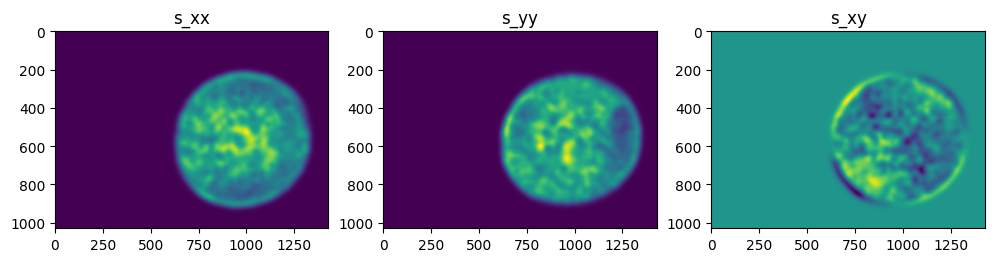

In [104]:
fig, axs = plt.subplots(1,3,figsize=(12,12))
for i,name in enumerate(["s_xx","s_yy","s_xy"]):
    im = S[i,:,:]
    axs[i].imshow(im) # , cmap="gray"
    axs[i].set_title(name)
    # fig.colorbar(im, ax=axs[i])
plt.show()

In [113]:
S_xx = S[0,:,:]
S_yy = S[1,:,:]

Gp = (S_xx.T @ S_xx)
Gg = (S_yy.T @ S_yy)

In [138]:
linalg.matrix_norm(Tensor(S_xx) - Tensor(S_yy), ord=2)

tensor(21520.8652)

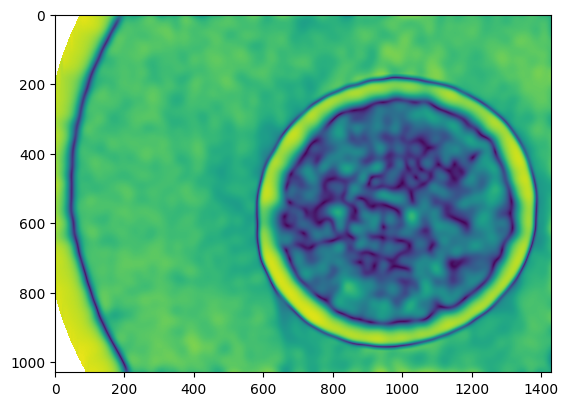

In [62]:
plt.imshow(anisotropy)
plt.show()

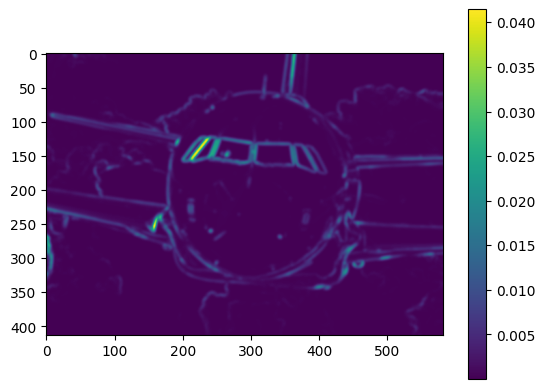

In [7]:
plt.imshow(np.linalg.norm(val,axis=0))
plt.colorbar()
plt.show()

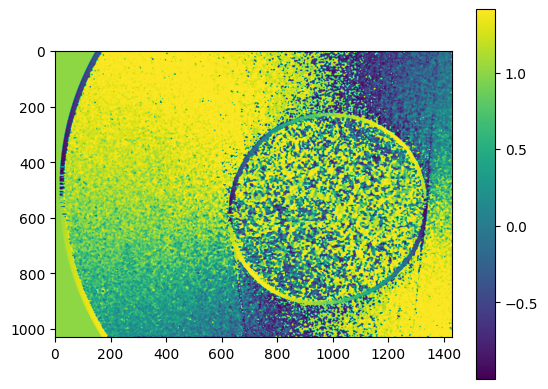

In [82]:
plt.imshow(np.sum(vec,axis=0))
plt.colorbar()
plt.show()

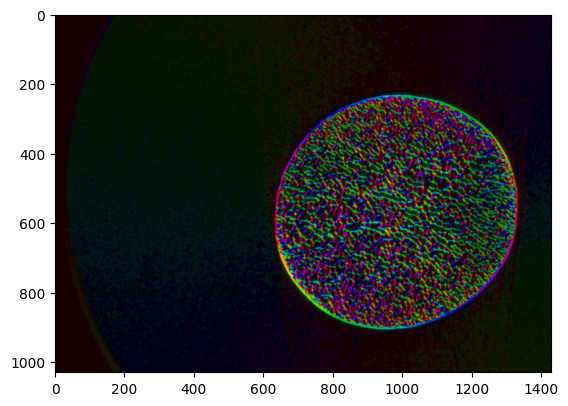

In [77]:
orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1], vec[0])/np.pi).reshape(im.shape))
# plt.imshow(orientation_st_rgba)
plt.imshow(plt.cm.gray(im)*orientation_st_rgba)
plt.show()

/tmp/ipykernel_11450/257543950.py:1: RuntimeWarning: invalid value encountered in divide
  anisotropy = (1-val[0]/val[1]).reshape(im.shape)


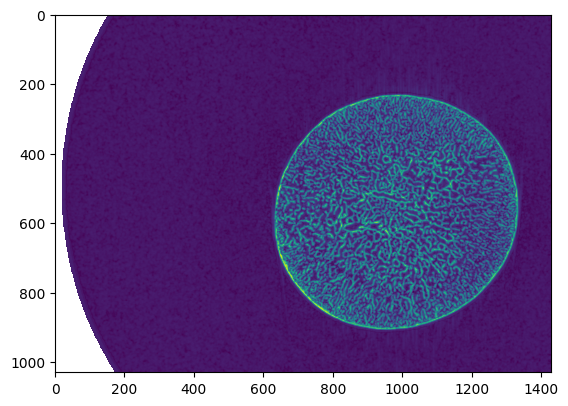

In [88]:
anisotropy = (1-val[0]/val[1]).reshape(im.shape)
plt.imshow(im * anisotropy)
plt.show()

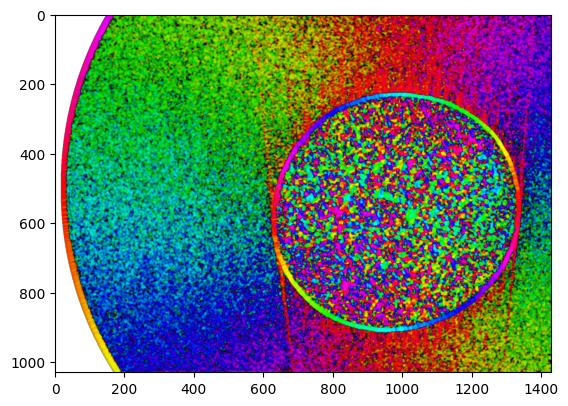

In [89]:
plt.imshow(plt.cm.gray(anisotropy)*orientation_st_rgba)
plt.show()

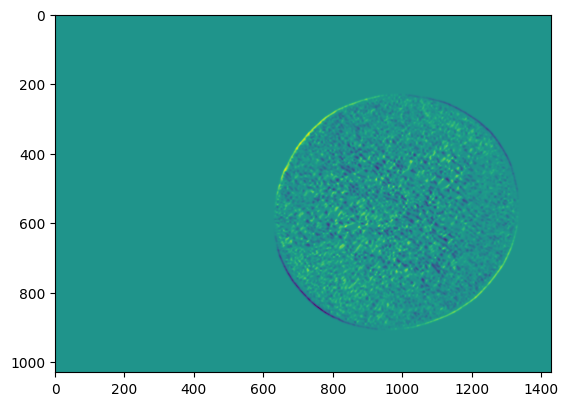

In [97]:
plt.imshow(S[2,...])
plt.show()

In [66]:

def structure_tensor(image, sigma, rho):
    """ Structure tensor for 2D image data
    Arguments:
        image: a 2D array of size N = rows*columns
        sigma: a noise scale, structures smaller than sigma will be 
            removed by smoothing
        rho: an integration scale giving the size over the neighborhood in 
            which the orientation is to be analysed
    Returns:
        an array with shape (3,N) containing elements of structure tensor 
            s_xx, s_yy, s_xy ordered acording to image.ravel()
    Author: vand@dtu.dk, 2019
    """
    
    # computing derivatives (scipy implementation truncates filter at 4 sigma)
    image = image.astype("float64")

    Ix = scipy.ndimage.gaussian_filter(image, sigma, order=[1,0], mode='nearest')
    Iy = scipy.ndimage.gaussian_filter(image, sigma, order=[0,1], mode='nearest')
    
    # integrating elements of structure tensor (scipy uses sequence of 1D)
    Jxx = scipy.ndimage.gaussian_filter(Ix**2, rho, mode='nearest')
    Jyy = scipy.ndimage.gaussian_filter(Iy**2, rho, mode='nearest')
    Jxy = scipy.ndimage.gaussian_filter(Ix*Iy, rho, mode='nearest')
    S = np.vstack((Jxx.ravel(), Jyy.ravel(), Jxy.ravel()));
    return S

def eig_special(S):
    """ Eigensolution for symmetric real 2-by-2 matrices
    Arguments:
        S: an array with shape (3,N) containing structure tensor
    Returns:
        val: an array with shape (2,N) containing sorted eigenvalues
        vec: an array with shape (2,N) containing eigenvector corresponding
            to the smallest eigenvalue (the other is orthogonal to the first)
    Author: vand@dtu.dk, 2019
    """

    val = 0.5*(S[0]+S[1]+np.outer(np.array([-1,1]), np.sqrt((S[0]-S[1])**2+4*S[2]**2)))
    vec = np.vstack((-S[2],S[0]-val[0])) # y will be positive
    aligned = S[2]==0 # dealing with diagonal matrices
    vec[:,aligned] = 1-np.argsort(S[0:2,aligned], axis=0)
    vec = vec/np.sqrt(vec[0]**2+vec[1]**2) # normalizing
    return val, vec

def solve_flow(S):
    """ Solving 1D optic flow, returns LLS optimal x for flow along y axis
        ( x is a solution to S[0]*x=S[2] )
    Arguments:
        S: an array with shape (3,N) containing 2D structure tensor
    Returns:
        x: an array with shape (1,N) containing x components of the flow
    Author: vand@dtu.dk, 2019
    """
    aligned = S[0]==0 # 0 or inf solutions
    x = np.zeros((1,S.shape[1]))
    x[0,~aligned] = - S[2,~aligned]/S[0,~aligned]
    return x # returning shape (1,N) array for consistancy with 3D case

#% HELPING FUNCTIONS FOR VISUALIZATION

def plot_orientations(ax, dim, vec, s = 5):
    """ Helping function for adding orientation-quiver to the plot.
    Arguments: plot axes, image shape, orientation, arrow spacing.
    """
    vx = vec[0].reshape(dim)
    vy = vec[1].reshape(dim)
    xmesh, ymesh = np.meshgrid(np.arange(dim[0]), np.arange(dim[1]), indexing='ij')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],vy[s//2::s,s//2::s],vx[s//2::s,s//2::s],color='r',angles='xy')
    ax.quiver(ymesh[s//2::s,s//2::s],xmesh[s//2::s,s//2::s],-vy[s//2::s,s//2::s],-vx[s//2::s,s//2::s],color='r',angles='xy')

def polar_histogram(ax, distribution, cmap = 'hsv'):
    """ Helping function for producing polar histogram.
    Arguments: plot axes, oriantation distribution, colormap.
    """
    N = distribution.size
    bin_centers_full = (np.arange(2*N)+0.5)*np.pi/N # full circle (360 deg)
    distribution_full = np.r_[distribution,distribution]/max(distribution) # full normalized distribution
    x = np.r_[distribution_full*np.cos(bin_centers_full),0]
    y = np.r_[distribution_full*np.sin(bin_centers_full),0]
    triangles = np.array([(i, np.mod(i-1,2*N), 2*N) for i in range(2*N)]) # triangles[0] is symmetric over 0 degree
    triangle_centers_full = (np.arange(2*N))*np.pi/N # a triangle covers area BETWEEN two bin_centers
    triangle_colors = np.mod(triangle_centers_full, np.pi)/np.pi # from 0 to 1-(1/2N)
    ax.tripcolor(y, x, triangles, facecolors=triangle_colors, cmap=cmap, vmin = 0.0, vmax = 1.0)
    ax.set_aspect('equal')
    ax.set_xlim([-1,1])
    ax.set_ylim([1,-1]) 

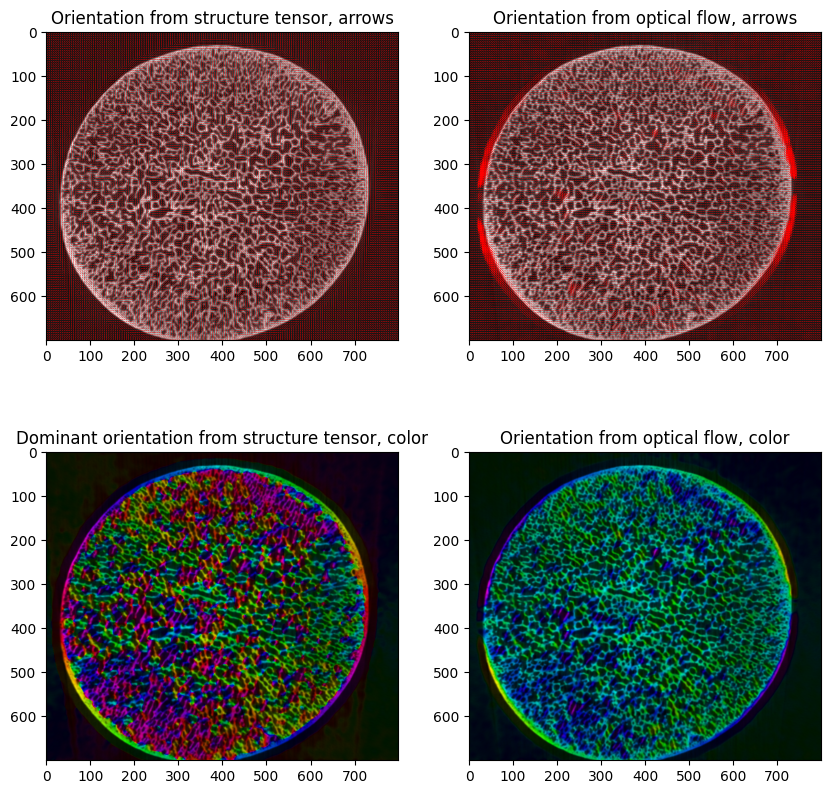

In [69]:
image = skimage.io.imread('test-data/femur.png')
image = image[200:900, 600:1400]
# computing structure tensor, orientation and optical flow
sigma = 0.5
rho = 5
S = structure_tensor(image,sigma,rho)
val,vec = eig_special(S) # dominant orientation
fx = solve_flow(S) # optical flow

# visualization
figsize = (10,10)
fy = np.ones(image.shape)
fig, ax = plt.subplots(2,2,figsize=figsize)

ax[0][0].imshow(image,cmap=plt.cm.gray)
plot_orientations(ax[0][0], image.shape, vec)
ax[0][0].set_title('Orientation from structure tensor, arrows')
ax[0][1].imshow(image,cmap=plt.cm.gray)
plot_orientations(ax[0][1], image.shape, np.r_[fx,np.ones((1,image.size))])
ax[0][1].set_title('Orientation from optical flow, arrows')
intensity_rgba = plt.cm.gray(image)
orientation_st_rgba = plt.cm.hsv((np.arctan2(vec[1],vec[0])/np.pi).reshape(image.shape))
orientation_of_rgba = plt.cm.hsv((np.arctan2(1,fx)/np.pi).reshape(image.shape))
ax[1][0].imshow(intensity_rgba*orientation_st_rgba)
ax[1][0].set_title('Dominant orientation from structure tensor, color')
ax[1][1].imshow(intensity_rgba*orientation_of_rgba)
ax[1][1].set_title('Orientation from optical flow, color')
plt.show()